# Modelo de Machine Learning

## Carga de librerías necesarias

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import (classification_report, confusion_matrix,
                             accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, roc_curve, silhouette_score)
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

## Ingesta de datos preprocesados

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Analítica Descriptiva/Trabajo Final/notebooks/online_gaming_behavior_preprocessed.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40034 entries, 0 to 40033
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Age                        40034 non-null  float64
 1   PlayTimeHours              40034 non-null  float64
 2   GameDifficulty             40034 non-null  object 
 3   SessionsPerWeek            40034 non-null  float64
 4   AvgSessionDurationMinutes  40034 non-null  float64
 5   PlayerLevel                40034 non-null  float64
 6   AchievementsUnlocked       40034 non-null  float64
 7   EngagementLevel            40034 non-null  object 
 8   AvgHoursPerSession         40034 non-null  float64
 9   Gender_Male                40034 non-null  bool   
 10  Location_Europe            40034 non-null  bool   
 11  Location_Other             40034 non-null  bool   
 12  Location_USA               40034 non-null  bool   
 13  GameGenre_RPG              40034 non-null  boo

## Algunas comprobaciones previas

In [ ]:
# Separar features y target para clasificación (EngagementLevel)

# Variables numéricas y categóricas one-hot encoded
feature_cols = df.drop(columns=['EngagementLevel_enc', 'EngagementLevel', 'GameDifficulty']).columns


# Target: EngagementLevel_enc (asumiendo: 0=Low, 1=Medium, 2=High)
X = df[feature_cols]
y = df['EngagementLevel_enc']

In [ ]:
# Verificar valores nulos
print(f"Valores nulos por columna:")
null_counts = X.isnull().sum()
if null_counts.sum() > 0:
    print(null_counts[null_counts > 0])
else:
    print("No hay valores nulos")

Valores nulos por columna:
No hay valores nulos


In [ ]:
# Verificar infinitos
print(f"Verificando valores infinitos...")
inf_mask = np.isinf(X.select_dtypes(include=[np.number]))
if inf_mask.any().any():
    print("ENCONTRADOS valores infinitos:")
    for col in X.select_dtypes(include=[np.number]).columns:
        inf_count = np.isinf(X[col]).sum()
        if inf_count > 0:
            print(f"  - {col}: {inf_count} valores infinitos")

    # Reemplazar infinitos con NaN y luego con la mediana
    X = X.replace([np.inf, -np.inf], np.nan)
    for col in X.select_dtypes(include=[np.number]).columns:
        if X[col].isnull().any():
            median_val = X[col].median()
            X[col].fillna(median_val, inplace=True)
            print(f"  ✓ {col}: infinitos reemplazados con mediana ({median_val:.4f})")
else:
    print("✅ No hay valores infinitos")

Verificando valores infinitos...
ENCONTRADOS valores infinitos:
  - AvgHoursPerSession: 1967 valores infinitos
  ✓ AvgHoursPerSession: infinitos reemplazados con mediana (1.2043)


In [ ]:
# Verificar valores extremadamente grandes
print(f"Verificando valores extremos...")
for col in X.select_dtypes(include=[np.number]).columns:
    max_val = X[col].max()
    min_val = X[col].min()
    if abs(max_val) > 1e10 or abs(min_val) > 1e10:
        print(f"⚠️ {col}: rango [{min_val:.2e}, {max_val:.2e}]")
        # Aplicar clipping
        percentile_99 = X[col].quantile(0.99)
        percentile_01 = X[col].quantile(0.01)
        X[col] = X[col].clip(lower=percentile_01, upper=percentile_99)
        print(f"  ✓ Valores recortados a percentiles 1-99")



Verificando valores extremos...


In [ ]:
# Verificación final
print(f"DATOS LIMPIOS:")
print(f"  - Shape: {X.shape}")
print(f"  - Tipos de datos: {X.dtypes.value_counts().to_dict()}")
print(f"  - Rango de valores:")
print(X.describe().loc[['min', 'max']].T)


DATOS LIMPIOS:
  - Shape: (40034, 19)
  - Tipos de datos: {dtype('bool'): 10, dtype('float64'): 8, dtype('int64'): 1}
  - Rango de valores:
                                min        max
Age                       -1.691961   1.693448
PlayTimeHours             -1.009377   1.008007
SessionsPerWeek            0.000000   1.000000
AvgSessionDurationMinutes -1.000000   0.988235
PlayerLevel               -1.701956   1.726053
AchievementsUnlocked       0.000000   1.000000
AvgHoursPerSession         0.000019  23.991848
GameDifficulty_enc         0.000000   2.000000
PlayIntensity             -1.000000   0.988235


In [ ]:
# División train-test (80-20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Tamaño del conjunto de entrenamiento: {X_train.shape}")
print(f"Tamaño del conjunto de prueba: {X_test.shape}")
print(f"\nDistribución del target en entrenamiento:")
print(y_train.value_counts(normalize=True))

Tamaño del conjunto de entrenamiento: (32027, 19)
Tamaño del conjunto de prueba: (8007, 19)

Distribución del target en entrenamiento:
EngagementLevel_enc
1    0.483935
2    0.258188
0    0.257876
Name: proportion, dtype: float64


## Modelo 1: REGRESIÓN LOGÍSTICA

In [ ]:
# Entrenar modelo
lr_model = LogisticRegression(
    max_iter=1000,
    random_state=42,
    multi_class='multinomial',
    class_weight='balanced'
)
lr_model.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000,
                   multi_class='multinomial', random_state=42)

In [ ]:
# Predicciones
y_pred_lr = lr_model.predict(X_test)
y_pred_proba_lr = lr_model.predict_proba(X_test)

In [ ]:
# Métricas
print("MÉTRICAS DE EVALUACIÓN:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_lr):.4f}")
print(f"Precision (weighted): {precision_score(y_test, y_pred_lr, average='weighted'):.4f}")
print(f"Recall (weighted): {recall_score(y_test, y_pred_lr, average='weighted'):.4f}")
print(f"F1-Score (weighted): {f1_score(y_test, y_pred_lr, average='weighted'):.4f}")

print("\nCLASSIFICATION REPORT:")
print(classification_report(y_test, y_pred_lr,
                          target_names=['Low', 'Medium', 'High']))

MÉTRICAS DE EVALUACIÓN:
Accuracy: 0.8373
Precision (weighted): 0.8461
Recall (weighted): 0.8373
F1-Score (weighted): 0.8384

CLASSIFICATION REPORT:
              precision    recall  f1-score   support

         Low       0.73      0.87      0.79      2065
      Medium       0.90      0.79      0.84      3875
        High       0.87      0.90      0.88      2067

    accuracy                           0.84      8007
   macro avg       0.83      0.85      0.84      8007
weighted avg       0.85      0.84      0.84      8007



In [ ]:
# Cross-validation
cv_scores_lr = cross_val_score(lr_model, X_train, y_train, cv=5, scoring='accuracy')
print(f"Cross-Validation Accuracy: {cv_scores_lr.mean():.4f} (+/- {cv_scores_lr.std():.4f})")

Cross-Validation Accuracy: 0.8317 (+/- 0.0031)


In [ ]:
# Feature importance (coeficientes)
feature_importance_lr = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': np.abs(lr_model.coef_).mean(axis=0)
}).sort_values('Importance', ascending=False)

print("TOP 10 FEATURES MÁS IMPORTANTES:")
print(feature_importance_lr.head(10))



🔝 TOP 10 FEATURES MÁS IMPORTANTES:
                      Feature  Importance
18              PlayIntensity    4.705231
2             SessionsPerWeek    4.042266
3   AvgSessionDurationMinutes    0.829957
5        AchievementsUnlocked    0.490724
4                 PlayerLevel    0.141999
1               PlayTimeHours    0.100055
6          AvgHoursPerSession    0.072778
9              Location_Other    0.038785
14         GameGenre_Strategy    0.033003
11              GameGenre_RPG    0.026390


La Regresión Logística obtiene una **accuracy del 83.7%**, con métricas equilibradas entre clases. El modelo funciona correctamente para capturar patrones lineales, destacándose especialmente en la identificación de la clase **High** (recall 90%). Sin embargo, muestra más confusión en la clase Medium, lo cual refleja superposición entre niveles de engagement.

Las variables más importantes —**PlayIntensity, SessionsPerWeek y AvgSessionDurationMinutes**— confirman que el engagement está fuertemente determinado por la frecuencia e intensidad de uso. Como modelo interpretable, sirve para validar relaciones esperadas, aunque queda limitado frente a patrones más complejos.

## Modelo 2: RANDOM FOREST

In [ ]:
# Entrenar modelo
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    class_weight='balanced',
    n_jobs=-1
)
rf_model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=10, n_jobs=-1,
                       random_state=42)

In [ ]:
# Predicciones
y_pred_rf = rf_model.predict(X_test)
y_pred_proba_rf = rf_model.predict_proba(X_test)

In [ ]:
# Métricas
print("MÉTRICAS DE EVALUACIÓN:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print(f"Precision (weighted): {precision_score(y_test, y_pred_rf, average='weighted'):.4f}")
print(f"Recall (weighted): {recall_score(y_test, y_pred_rf, average='weighted'):.4f}")
print(f"F1-Score (weighted): {f1_score(y_test, y_pred_rf, average='weighted'):.4f}")

print("\nCLASSIFICATION REPORT:")
print(classification_report(y_test, y_pred_rf,
                          target_names=['Low', 'Medium', 'High']))

MÉTRICAS DE EVALUACIÓN:
Accuracy: 0.9026
Precision (weighted): 0.9027
Recall (weighted): 0.9026
F1-Score (weighted): 0.9026

CLASSIFICATION REPORT:
              precision    recall  f1-score   support

         Low       0.88      0.89      0.89      2065
      Medium       0.91      0.92      0.92      3875
        High       0.91      0.88      0.90      2067

    accuracy                           0.90      8007
   macro avg       0.90      0.90      0.90      8007
weighted avg       0.90      0.90      0.90      8007



In [ ]:
# Cross-validation
cv_scores_rf = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='accuracy')
print(f"Cross-Validation Accuracy: {cv_scores_rf.mean():.4f} (+/- {cv_scores_rf.std():.4f})")

Cross-Validation Accuracy: 0.8982 (+/- 0.0035)


In [ ]:
# Feature importance
feature_importance_rf = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("TOP 10 FEATURES MÁS IMPORTANTES:")
print(feature_importance_rf.head(10))


TOP 10 FEATURES MÁS IMPORTANTES:
                      Feature  Importance
2             SessionsPerWeek    0.322183
18              PlayIntensity    0.281240
3   AvgSessionDurationMinutes    0.228261
6          AvgHoursPerSession    0.094011
1               PlayTimeHours    0.022317
4                 PlayerLevel    0.016362
5        AchievementsUnlocked    0.015590
0                         Age    0.007405
17         GameDifficulty_enc    0.002080
7                 Gender_Male    0.001241


El Random Forest mejora notablemente el rendimiento, alcanzando una **accuracy del 90.3%**, con métricas muy balanceadas entre clases. Esto sugiere un modelo robusto, capaz de capturar interacciones y no linealidades.

Las variables más influyentes coinciden con el modelo anterior: **SessionsPerWeek, PlayIntensity y AvgSessionDurationMinutes**. Las variables demográficas aportan muy poco, indicando que el comportamiento dentro del juego es el principal predictor. Es un modelo estable y con muy buen equilibrio entre desempeño e interpretabilidad.

## Modelo 3: GRADIENT BOOSTING

In [ ]:
# Entrenar modelo
gb_model = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)
gb_model.fit(X_train, y_train)

GradientBoostingClassifier(max_depth=5, random_state=42)

In [ ]:
# Predicciones
y_pred_gb = gb_model.predict(X_test)
y_pred_proba_gb = gb_model.predict_proba(X_test)

In [ ]:
# Métricas
print("MÉTRICAS DE EVALUACIÓN:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_gb):.4f}")
print(f"Precision (weighted): {precision_score(y_test, y_pred_gb, average='weighted'):.4f}")
print(f"Recall (weighted): {recall_score(y_test, y_pred_gb, average='weighted'):.4f}")
print(f"F1-Score (weighted): {f1_score(y_test, y_pred_gb, average='weighted'):.4f}")

print("\nCLASSIFICATION REPORT:")
print(classification_report(y_test, y_pred_gb,
                          target_names=['Low', 'Medium', 'High']))

MÉTRICAS DE EVALUACIÓN:
Accuracy: 0.9154
Precision (weighted): 0.9158
Recall (weighted): 0.9154
F1-Score (weighted): 0.9152

CLASSIFICATION REPORT:
              precision    recall  f1-score   support

         Low       0.92      0.88      0.90      2065
      Medium       0.91      0.95      0.93      3875
        High       0.93      0.88      0.90      2067

    accuracy                           0.92      8007
   macro avg       0.92      0.91      0.91      8007
weighted avg       0.92      0.92      0.92      8007



In [ ]:
# Cross-validation
cv_scores_gb = cross_val_score(gb_model, X_train, y_train, cv=5, scoring='accuracy')
print(f"Cross-Validation Accuracy: {cv_scores_gb.mean():.4f} (+/- {cv_scores_gb.std():.4f})")

Cross-Validation Accuracy: 0.9130 (+/- 0.0033)


In [ ]:
# Feature importance
feature_importance_gb = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': gb_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("TOP 10 FEATURES MÁS IMPORTANTES:")
print(feature_importance_gb.head(10))


TOP 10 FEATURES MÁS IMPORTANTES:
                      Feature  Importance
2             SessionsPerWeek    0.398544
18              PlayIntensity    0.310438
3   AvgSessionDurationMinutes    0.229406
5        AchievementsUnlocked    0.025207
4                 PlayerLevel    0.022692
6          AvgHoursPerSession    0.005239
1               PlayTimeHours    0.004361
0                         Age    0.001935
9              Location_Other    0.000302
17         GameDifficulty_enc    0.000288


El Gradient Boosting logra el mejor rendimiento, con **91.5% de accuracy** y excelente consistencia entre precisión, recall y F1-score. Presenta una gran capacidad para capturar diferencias sutiles en los patrones de juego, especialmente en la clase Medium (recall 95%).

Las importancias de variables refuerzan el mismo patrón: la **frecuencia, duración e intensidad del juego** son los mayores determinantes del engagement. Las demás variables aportan marginalmente.

## Combinación de modelos

In [ ]:
comparison_df = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest', 'Gradient Boosting'],
    'Accuracy': [
        accuracy_score(y_test, y_pred_lr),
        accuracy_score(y_test, y_pred_rf),
        accuracy_score(y_test, y_pred_gb)
    ],
    'Precision': [
        precision_score(y_test, y_pred_lr, average='weighted'),
        precision_score(y_test, y_pred_rf, average='weighted'),
        precision_score(y_test, y_pred_gb, average='weighted')
    ],
    'Recall': [
        recall_score(y_test, y_pred_lr, average='weighted'),
        recall_score(y_test, y_pred_rf, average='weighted'),
        recall_score(y_test, y_pred_gb, average='weighted')
    ],
    'F1-Score': [
        f1_score(y_test, y_pred_lr, average='weighted'),
        f1_score(y_test, y_pred_rf, average='weighted'),
        f1_score(y_test, y_pred_gb, average='weighted')
    ],
    'CV_Accuracy': [
        cv_scores_lr.mean(),
        cv_scores_rf.mean(),
        cv_scores_gb.mean()
    ]
})

print("TABLA COMPARATIVA:")
print(comparison_df.to_string(index=False))

best_model = comparison_df.loc[comparison_df['Accuracy'].idxmax(), 'Model']
print(f"\nMEJOR MODELO: {best_model}")

TABLA COMPARATIVA:
              Model  Accuracy  Precision   Recall  F1-Score  CV_Accuracy
Logistic Regression  0.837267   0.846131 0.837267  0.838360     0.831704
      Random Forest  0.902585   0.902682 0.902585  0.902578     0.898180
  Gradient Boosting  0.915449   0.915764 0.915449  0.915161     0.913042

MEJOR MODELO: Gradient Boosting


Los resultados muestran una mejora progresiva a medida que se utilizan modelos más flexibles:

- Regresión Logística: adecuada pero limitada por su linealidad.

- Random Forest: fuerte aumento en desempeño y captura de interacciones.

- Gradient Boosting: máximo rendimiento y mayor estabilidad.

El **Gradient Boosting se elige como mejor modelo** por su superioridad en todas las métricas y su capacidad para modelar relaciones complejas. Además, todos los modelos coinciden en que el engagement depende principalmente de variables de comportamiento del jugador, lo que refuerza la validez de los resultados.

## Visualizaciones

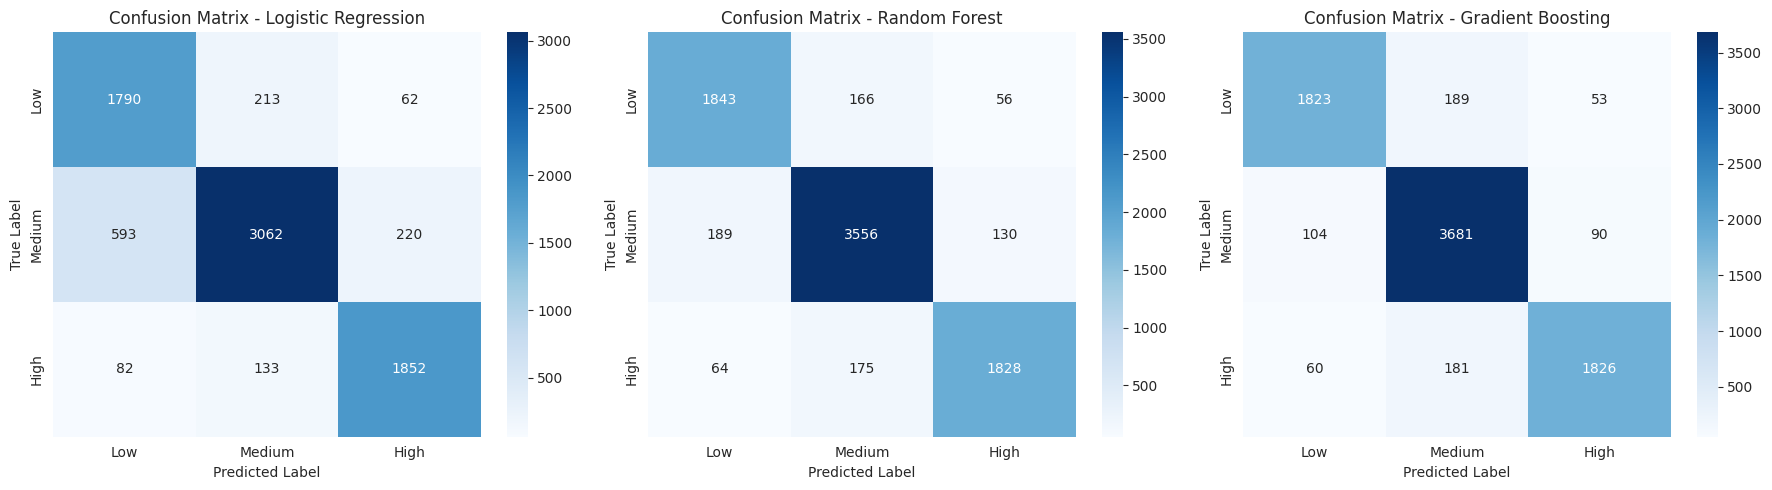

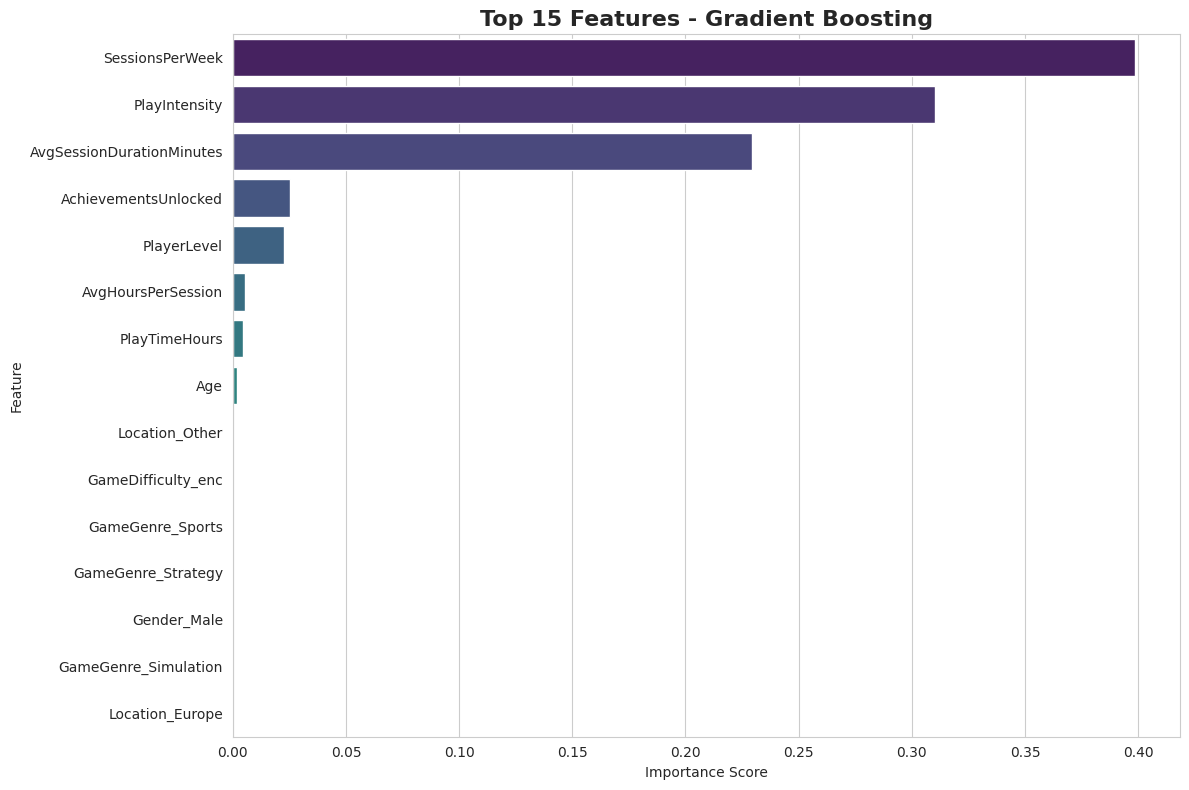

In [ ]:
# Matriz de confusión del mejor modelo (Random Forest)
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (y_pred, title) in enumerate([
    (y_pred_lr, 'Logistic Regression'),
    (y_pred_rf, 'Random Forest'),
    (y_pred_gb, 'Gradient Boosting')
]):
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                xticklabels=['Low', 'Medium', 'High'],
                yticklabels=['Low', 'Medium', 'High'])
    axes[idx].set_title(f'Confusion Matrix - {title}')
    axes[idx].set_ylabel('True Label')
    axes[idx].set_xlabel('Predicted Label')

plt.tight_layout()
plt.savefig('confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()

# Feature importance (Random Forest)
plt.figure(figsize=(12, 8))
top_features = feature_importance_gb.head(15)
sns.barplot(data=top_features, x='Importance', y='Feature', palette='viridis')
plt.title('Top 15 Features - Gradient Boosting', fontsize=16, fontweight='bold')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.savefig('feature_importance_gb.png', dpi=300, bbox_inches='tight')
plt.show()


## Clústering (Análisis complementario)

In [ ]:
# Seleccionar variables relevantes para clustering
clustering_features = [
    'PlayTimeHours', 'SessionsPerWeek', 'AvgSessionDurationMinutes',
    'PlayerLevel', 'AchievementsUnlocked'
]

X_cluster = df[clustering_features]

In [ ]:
# Determinar número óptimo de clusters (método del codo)
inertias = []
silhouette_scores = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_cluster)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_cluster, kmeans.labels_))

In [ ]:
# Aplicar K-Means con k=3 (basado en EngagementLevel)
kmeans_final = KMeans(n_clusters=3, random_state=42, n_init=10)
df['Cluster'] = kmeans_final.fit_predict(X_cluster)

print("DISTRIBUCIÓN DE CLUSTERS:")
print(df['Cluster'].value_counts().sort_index())

DISTRIBUCIÓN DE CLUSTERS:
Cluster
0    13331
1    13434
2    13269
Name: count, dtype: int64


In [ ]:
# Comparar clusters con EngagementLevel original
print("RELACIÓN CLUSTER vs ENGAGEMENT LEVEL:")
print(pd.crosstab(df['Cluster'], df['EngagementLevel']))

\RELACIÓN CLUSTER vs ENGAGEMENT LEVEL:
EngagementLevel  High   Low  Medium
Cluster                            
0                3274  3946    6111
1                3506  3448    6480
2                3556  2930    6783


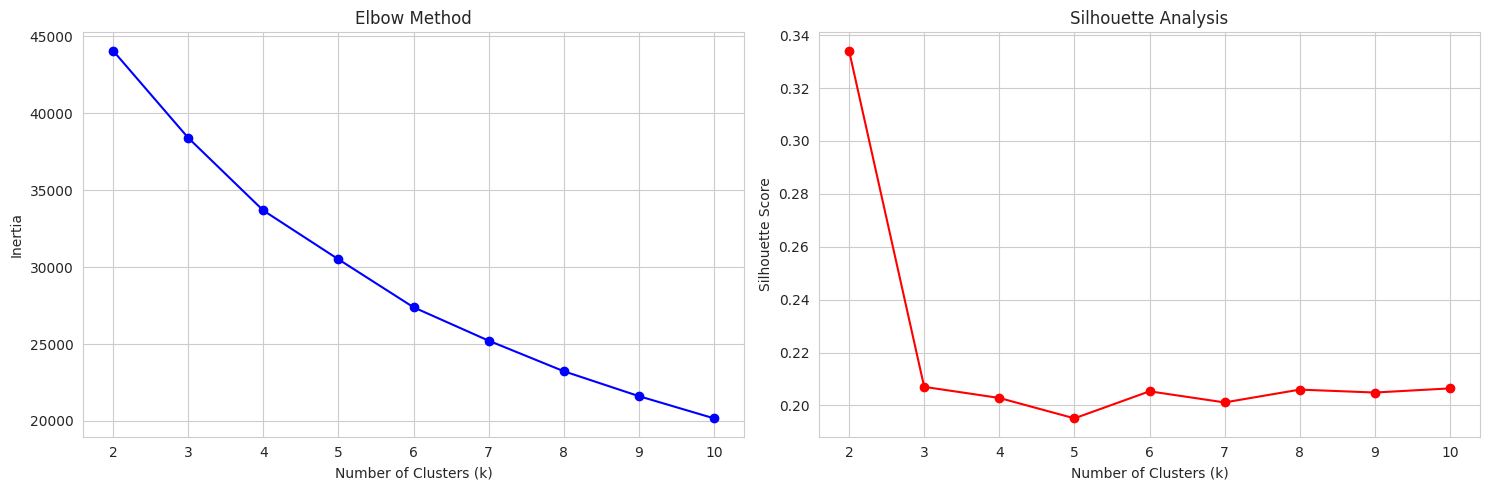

In [ ]:
# Visualización: Método del codo
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].plot(K_range, inertias, 'bo-')
axes[0].set_xlabel('Number of Clusters (k)')
axes[0].set_ylabel('Inertia')
axes[0].set_title('Elbow Method')
axes[0].grid(True)

axes[1].plot(K_range, silhouette_scores, 'ro-')
axes[1].set_xlabel('Number of Clusters (k)')
axes[1].set_ylabel('Silhouette Score')
axes[1].set_title('Silhouette Analysis')
axes[1].grid(True)

plt.tight_layout()
plt.savefig('clustering_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

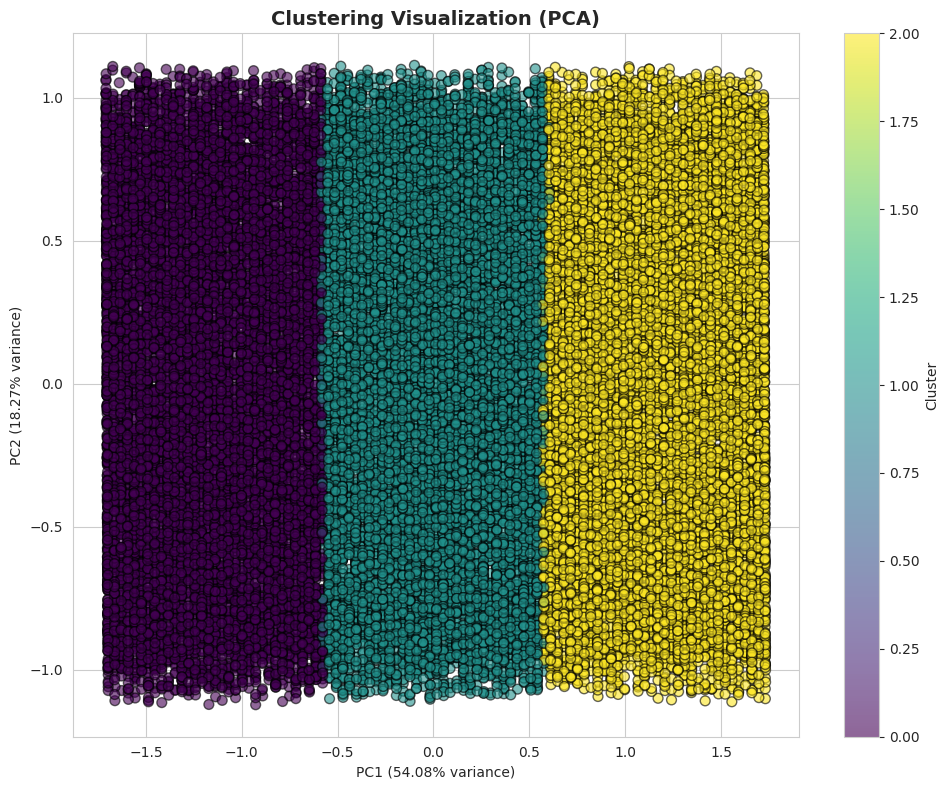

Varianza explicada por PC1 y PC2: 72.36%


In [ ]:
# PCA para visualización de clusters
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_cluster)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1],
                     c=df['Cluster'], cmap='viridis',
                     alpha=0.6, edgecolors='k', s=50)
plt.colorbar(scatter, label='Cluster')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
plt.title('Clustering Visualization (PCA)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('clustering_pca.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Varianza explicada por PC1 y PC2: {sum(pca.explained_variance_ratio_):.2%}")


Los clústeres tienen tamaños equilibrados, lo que indica una segmentación estable. La relación entre clusters y engagement muestra tendencias claras:

- Cluster 0: predominan usuarios de bajo engagement.

- Cluster 1: perfil intermedio.

- Cluster 2: mayor presencia de High.

Si bien no replican completamente las etiquetas, los grupos reflejan **estilos de juego distintos**, lo que valida la estructura natural de los datos. Además, los primeros dos componentes del PCA explican el **72.36% de la varianza**, mostrando que los patrones principales se capturan bien en un espacio reducido.


 ## Reflexión sobre cómo llevar el proyecto a producción y mantener el sistema actualizado

Para llevar a producción un sistema que prediga y explique el nivel de engagement de jugadores en videojuegos online, es necesario transformar el análisis exploratorio y el modelo desarrollado en un flujo automatizado, estable y escalable. Dado que el objetivo final es **diseñar estrategias de fidelización y optimizar la monetización**, el pipeline en producción debería integrarse de forma continua con la plataforma del videojuego y permitir decisiones rápidas basadas en datos actualizados.

En primer lugar, se requiere automatizar la **ingesta de datos de comportamiento y demográficos**. En un entorno real, estas variables suelen provenir de logs de actividad del juego, sistemas de autenticación y bases transaccionales. Su actualización debería gestionarse mediante workflows programados u orquestadores como **Airflow o Prefect**, que permitan ejecutar procesos de extracción, validación y transformación de forma continua (por ejemplo, por hora o por día, según la dinámica del juego).

En segundo lugar, el modelo de engagement debe estar empaquetado en un entorno reproducible —por ejemplo, usando **Docker**— y versionado con herramientas de experimentación como **MLflow**, a fin de asegurar trazabilidad sobre métricas, hiperparámetros y datasets utilizados. Esto también habilita reentrenamientos programados cuando ingresan nuevos jugadores, cambian las dinámicas del juego o se detecta **model drift** (algo común cuando cambian las mecánicas del gameplay o aparecen nuevas modalidades).

El despliegue del modelo podría realizarse mediante un servicio de inferencia (una API con **FastAPI**, Flask o servicios cloud como AWS Sagemaker o Vertex AI), que reciba datos de cada usuario y devuelva en tiempo real o por batch el nivel de engagement estimado. Estas predicciones se almacenarían en una base analítica diseñada para alimentar tanto decisiones tácticas (por ejemplo, **trigger de ofertas personalizadas o misiones específicas**) como análisis estratégicos de largo plazo.

Finalmente, mantener actualizado el tablero de monitoreo es fundamental para que el equipo de producto, marketing o monetización pueda interpretar el estado del engagement en tiempo real. Este dashboard —ya sea en **Power BI, Looker, Tableau o Streamlit**— debería conectarse directamente a la base donde se guardan las predicciones, renovándose con una frecuencia predefinida. Además, en un escenario de uso intensivo, se recomienda incorporar monitoreo sistemático del desempeño del modelo (precisión, estabilidad, drift) y del sistema (latencia, errores), empleando herramientas como **Prometheus + Grafana** o servicios equivalentes en la nube.

En conjunto, este enfoque permitiría convertir el modelo en un **sistema inteligente de apoyo a las estrategias de fidelización**, capaz de adaptarse dinámicamente al comportamiento real de los jugadores y de alimentar decisiones que optimicen la retención y la monetización a lo largo del ciclo de vida del usuario.
